In [43]:
from qiskit import *
from qiskit.visualization import plot_histogram
import numpy as np
import networkx as nx
from scipy.optimize import minimize
from operator import itemgetter
import matplotlib.pyplot as plt
from qiskit_ibm_provider import IBMProvider
from qiskit import Aer

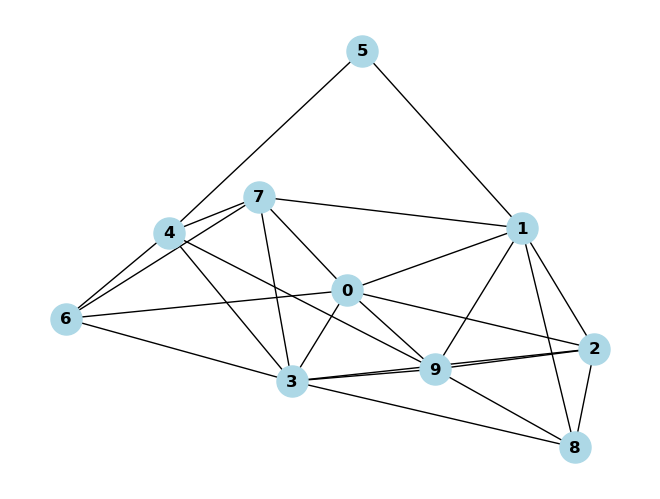

In [52]:
G = nx.gnm_random_graph(10,25)
#nodes = []
#for i in range(10):
#    nodes.append(i)
#print(nodes)
#edges = [(0,1),(0,2),(1,2),(1,3),(1,4),(1,5),(2,5),(3,4),(3,5),(4,5)]
#G.add_nodes_from(nodes)
#G.add_edges_from(edges)
n = G.number_of_nodes()
Q = np.zeros((n,n))

P = 400
w = np.array(nx.adjacency_matrix(G, nodelist=range(n))).tolist()
#print(w, G.edges)
for i,j in G.edges():
    Q[i,j]=P/2*w[i,j]
    Q[j,i]=P/2*w[j,i]
for i in range(n):
    for j in range(n):
        if (i,j) not in G.edges() and (j,i) not in G.edges():
            Q[i,j]=w[i,j]
            Q[j,i]=w[j,i]

#np.fill_diagonal(Q,-1)
vc = [0]*n
for i in range(n):
    for j in range(n):
       # if i<j: (including both upper and lower left triangle)
            if Q[i,j] != 0:
                vc[i] += 1


for i in range(n):
    for j in range(n):
        if i == j:
            Q[i,j] = -1
        
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=500, node_color='lightblue', font_size=12, font_weight='bold')
plt.show()
#print(Q)


In [35]:
import matplotlib.pyplot as plt

cliques = list(nx.find_cliques(G))
print(cliques)
for x in cliques:
    if x==max(cliques, key=len):
        subgraph = G.subgraph(x)
        
        pos = nx.spring_layout(subgraph)
        nx.draw(subgraph, pos, with_labels=True, node_size=500, node_color='lightblue', font_size=12, font_weight='bold')
        plt.show()
        print("Yes")
        G.remove_nodes_from(x)

[]


In [53]:
def append_zz_term(qc, q1, q2, gamma):
    qc.cx(q1,q2)
    qc.rz(2*gamma, q2)
    qc.cx(q1,q2)
    return qc


# In[134]:


def append_z_term(qc, q1, gamma):
    qc.rz(2*gamma, q1)
    return qc


# In[135]:


def append_x_term(qc, q1, beta):
    qc.rx(2*beta, q1)
    return qc


# In[282]:


def get_cost_operator_circuit(G, gamma):
    N = G.number_of_nodes()
    qc = QuantumCircuit(N,N)
    for i in G.nodes():
        append_z_term(qc, i, gamma)
#   for i in range(n):
#        for j in range(n):
#            if i<j:
#                append_zz_term(qc,i,j,gamma)
    for i,j in G.edges():
        append_zz_term(qc,i,j,gamma)
#    for i in G.nodes():
#        append_z_term(qc, i, gamma)
    return qc


# In[283]:


def get_mixer_operator_circuit(G, beta):
    N = G.number_of_nodes()
    qc = QuantumCircuit(N,N)
    for n in G.nodes():
        append_x_term(qc, n, beta)
    return qc


# In[284]:


def get_qaoa_circuit(G, beta, gamma):
    assert(len(beta) == len(gamma))
    p = len(beta)
    N = G.number_of_nodes()
    qc = QuantumCircuit(N,N)

    # First apply Hadamard layer
    qc.h(range(N))
    
    #Second apply p alternating operators
    for i in range(p):
        qc = qc.compose(get_cost_operator_circuit(G, gamma[i]))  
        qc = qc.compose(get_mixer_operator_circuit(G, beta[i]))
        
    #Finally, measure the result
    qc.barrier(range(N))
    qc.measure(range(N), range(N))

    return qc


# In[285]:


def invert_counts(counts):
    return {k[::-1]:v for k,v in counts.items()}


# In[286]:


def qubo_obj(x,G):
    summ = 0
    for i in range(n):
        for j in range(n):
            summ += Q[i,j]*int(x[i])*int(x[j])
    return summ


# In[287]:


def compute_qubo_energy(counts, G):
    energy = 0
    total_counts = 0
    for meas, meas_count in counts.items():
        obj_for_meas = qubo_obj(meas, G)
        energy += obj_for_meas * meas_count
        total_counts += meas_count
    return energy/total_counts


# In[288]:


def get_black_box_objective(G,p):
    backend = Aer.get_backend('qasm_simulator')
    def f(theta):
        beta = theta[:p]
        gamma = theta[p:]
        qc = get_qaoa_circuit(G, beta, gamma)
        counts = execute(qc, backend, seed_simulator = 10, shots = 100000).result().get_counts()
        return compute_qubo_energy(invert_counts(counts), G)
    return f

In [54]:
import time
start = time.time()

p = 1
obj = get_black_box_objective(G, p)

init_point = np.random.rand(2*p)
res_sample = minimize(obj, init_point, method = 'COBYLA', options = {'maxiter':1000, 'disp':True})

optimal_theta = res_sample['x']
provider = IBMProvider()
#backend0 = provider.get_backend('ibm_auckland')
backend = Aer.get_backend('qasm_simulator')
qc = get_qaoa_circuit(G, optimal_theta[:p], optimal_theta[p:])
#qc = transpile(qc, backend0, optimization_level = 3)
counts = invert_counts(execute(qc, backend, shots = 100000).result().get_counts())


end = time.time()
print((end-start),"s")


   Normal return from subroutine COBYLA

   NFVALS =   33   F = 1.294380E+03    MAXCV = 0.000000E+00
   X = 1.140706E+00   1.860842E-01
16.642462730407715 s


Best string:1000010010 with cut:-3.0


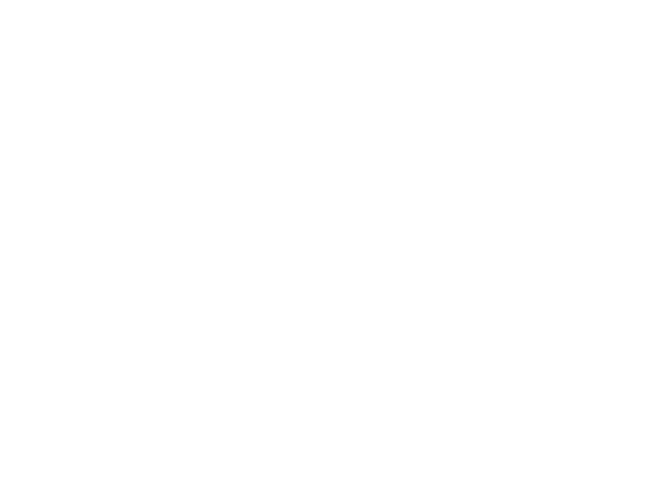

[] []


In [58]:
best_cut, best_solution = min([(qubo_obj(x, G), x) for x in counts.keys()], key=itemgetter(0))
print(f"Best string:{best_solution} with cut:{best_cut}")
colors = ['r' if best_solution[node]=='1' else 'b' for node in G]

pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=500, node_color=colors, font_size=12, font_weight='bold')
plt.show()

cliques =[]
nc_list = []
zeros_list_dict = {}
for i in G:
    zeros_list_dict[i]=[]
    if best_solution[i]=='1':
        zeros_list_dict[i].append(i)
        for j in G:
            if w[i,j]==1:
                    zeros_list_dict[i].append(j)
    for k in zeros_list_dict[i]:
        for l in zeros_list_dict[i]:
            if k!=l:
                if w[k,l]==0:
                    zeros_list_dict[i].remove(l)
                    nc_list.append(l)
    
    cliques.append(zeros_list_dict[i])
for x in cliques:
    if x==max(cliques, key=len):
        subgraph = G.subgraph(x)
        
        pos = nx.spring_layout(subgraph)
        nx.draw(subgraph, pos, with_labels=True, node_size=500, node_color='lightblue', font_size=12, font_weight='bold')
        plt.show()
        G.remove_nodes_from(x)
#        cliques.append(nc_list)
print(cliques, nc_list)

In [75]:
import matplotlib.pyplot as plt
cliques = list(nx.find_cliques(G))
print(cliques)
for x in cliques:
    if x==max(cliques, key=len):
        subgraph = G.subgraph(x)
        
        pos = nx.spring_layout(subgraph)
        nx.draw(subgraph, pos, with_labels=True, node_size=500, node_color='lightblue', font_size=12, font_weight='bold')
        plt.show()
        print("Yes")
#        G1.remove_nodes_from(x)

[]


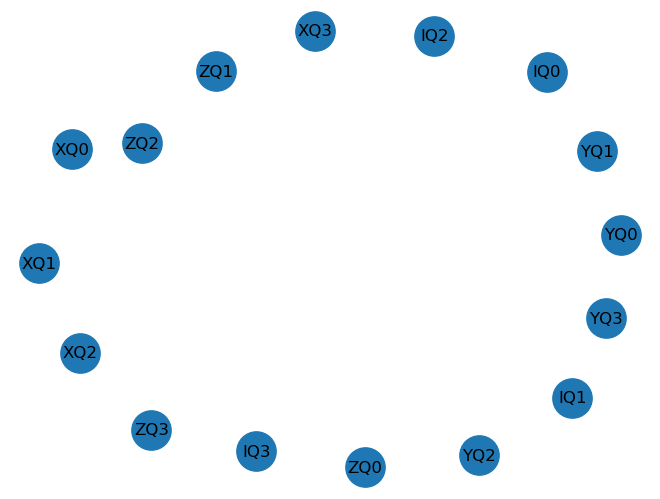

In [198]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a graph
G = nx.Graph()

# Define qubits
qubits = ['Q0', 'Q1', 'Q2', 'Q3']

# Define Pauli operators
pauli_operators = ['I', 'X', 'Y', 'Z']

# Add nodes (Pauli operators) to the graph
for qubit in qubits:
    for pauli in pauli_operators:
        G.add_node(f"{pauli}{qubit}")

# Determine commutation relationships
commutation_relations = []
for p1 in G.nodes():
    for p2 in G.nodes():
        if p1 != p2:
            commutator = f"[{p1}, {p2}]"
            if commutator == '[I, I]' or commutator == '[I, X]' or commutator == '[I, Y]' or commutator == '[I, Z]' or commutator == '[X, X]' or commutator == '[Y, Y]' or commutator == '[Z, Z]':
                commutation_relations.append((p1, p2))

# Add edges for commutation relationships
G.add_edges_from(commutation_relations)

# Visualize the graph
pos = nx.spring_layout(G)
labels = {node: node for node in G.nodes()}

nx.draw(G, pos, with_labels=True, node_size=800)
plt.show()

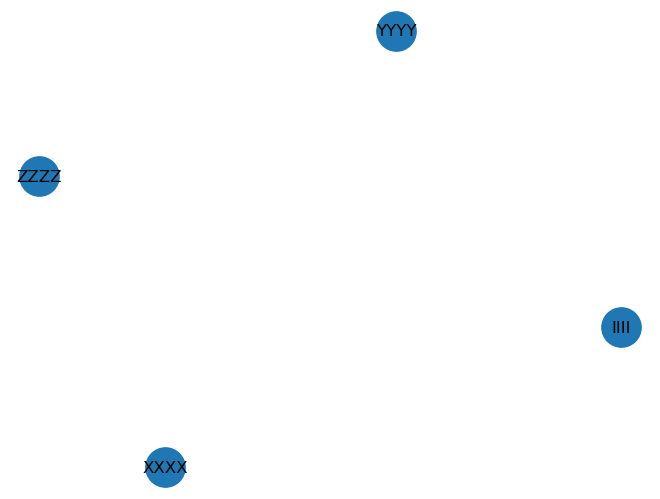

In [207]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a graph
G = nx.Graph()

# Define qubits
qubits = ['Q0', 'Q1', 'Q2', 'Q3']

# Define Pauli operators
pauli_operators = ['I', 'X', 'Y', 'Z']

# Add nodes (Pauli operators) to the graph
for qubit in qubits:
    for pauli in pauli_operators:
        G.add_node(f"{pauli}{pauli}{pauli}{pauli}")

# Determine commutation relationships
commutation_relations = []
for p1 in G.nodes():
    for p2 in G.nodes():
        if p1 != p2:
            commutator = f"[{p1}, {p2}]"
            if commutator == '[I, I]' or commutator == '[I, X]' or commutator == '[I, Y]' or commutator == '[I, Z]' or commutator == '[X, X]' or commutator == '[Y, Y]' or commutator == '[Z, Z]':
                commutation_relations.append((p1, p2, commutator))

# Add edges for commutation relationships with labels
G.add_edges_from(commutation_relations)

# Visualize the graph
pos = nx.spring_layout(G)
edge_labels = {(edge[0], edge[1]): edge[2] for edge in commutation_relations}
labels = {node: node for node in G.nodes()}

nx.draw(G, pos, with_labels=True, node_size=800)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.show()

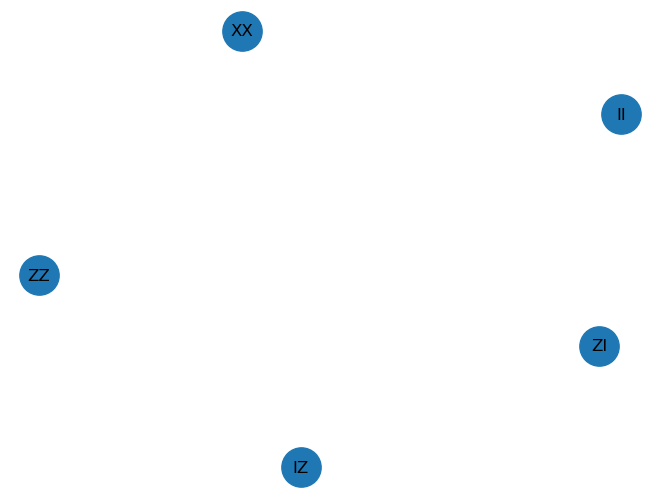

In [211]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a graph
G = nx.Graph()

# Define Pauli strings
pauli_strings = ['II', 'IZ', 'ZI', 'ZZ', 'XX']

# Add nodes (Pauli strings) to the graph
G.add_nodes_from(pauli_strings)

# Determine commutation relationships
commutation_relations = []
for p1 in pauli_strings:
    for p2 in pauli_strings:
        if p1 != p2:
            # Check if p1 and p2 commute
            commutator = f"[{p1}, {p2}]"
            if commutator == '0':
                commutation_relations.append((p1, p2, commutator))

# Add edges for commutation relationships with labels
G.add_edges_from(commutation_relations)

# Visualize the graph
pos = nx.spring_layout(G)
labels = {node: node for node in G.nodes()}

nx.draw(G, pos, with_labels=True, node_size=800)
plt.show()

In [212]:
n = G.number_of_nodes()
Q = np.zeros((n,n))

P = 400
w = np.array(nx.adjacency_matrix(G, nodelist=range(n))).tolist()
#print(w, G.edges)
for i,j in G.edges():
    Q[i,j]=P/2*w[i,j]
    Q[j,i]=P/2*w[j,i]
for i in range(n):
    for j in range(n):
        if (i,j) not in G.edges() and (j,i) not in G.edges():
            Q[i,j]=w[i,j]
            Q[j,i]=w[j,i]

#np.fill_diagonal(Q,-1)
vc = [0]*n
for i in range(n):
    for j in range(n):
       # if i<j: (including both upper and lower left triangle)
            if Q[i,j] != 0:
                vc[i] += 1


for i in range(n):
    for j in range(n):
        if i == j:
            Q[i,j] = -1
        
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=500, node_color='lightblue', font_size=12, font_weight='bold')
plt.show()

NetworkXError: Node 0 in nodelist is not in G